<a href="https://colab.research.google.com/github/walt-r/hate_speech_nlp/blob/main/nlp_proj_hate_speech_xlnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hate Speech Classification
## Detect toxic content to improve online conversations
Inspired by LAB_humor_questions


In [ ]:
# !wget https://github.com/ravi-ilango/acm-dec-2020-nlp/blob/main/lab5/humor_data.zip?raw=true -O humor_data.zip
!wget https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/data/labeled_data.csv -O hate_speech_data.csv

# !unzip humor_data.zip

--2021-03-25 06:02:51--  https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/data/labeled_data.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘hate_speech_data.csv’

hate_speech_data.cs     [ <=>                ] 104.48K  --.-KB/s    in 0.04s   

2021-03-25 06:02:51 (2.80 MB/s) - ‘hate_speech_data.csv’ saved [106991]



In [ ]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 2.0MB 5.6MB/s 
     |████████████████████████████████| 890kB 22.2MB/s 
     |████████████████████████████████| 3.2MB 31.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=f5e1595a2f352f6bf3207a18d2e7a82ba2adcf742a7561d1e574b6a6a7414257
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 4.6MB/s 


In [ ]:
import os 

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import torch

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split


## LAB


- Use the disaster_detection_bert as a reference 

- Load input data, tokenize and prepare tensors for training

- Instantiate a XLNet pretrained model

- Predict humor for few sentences

Note: Use 10K data from dataset, 
      train/validation split of 70/30,
      batch_size 32, 
      train for 3 epochs

### Check sample code from huggingface illustrating the use of XLNet
(https://huggingface.co/transformers/model_doc/xlnet.html#xlnetforsequenceclassification)

In [ ]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)

loss = outputs.loss
logits = outputs.logits

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

### Load data


In [ ]:
df = pd.read_csv('labeled_data_index.csv') #, error_bad_lines=False) 
# df = pd.read_csv('hate_speech_data.csv') #, error_bad_lines=False) 

# df = pd.read_pickle('hate_speech_data.p')

print (f"Number of records: {len(df)}")

df.head()

Number of records: 24783


,index,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
#
# text are stored in the variable text
# offensive/hate or not labels are stored in the variable class
#
# find and drop percent of target == 0 rows
import random

random.seed(42)
print(df.shape)
# df[df['target']==0].index.to_list()

# class 2 is neither hate_speech or offensive
drop_offensive = random.sample(df[df['class'] != 2].index.to_list(), 15000)

df = df.drop(index = drop_offensive)
print(df['class'].value_counts())


text = df.tweet.values

# df['target'] = df['class'].apply(lambda x: 1 if x == 2 else 0)
labels = df['class'].apply(lambda x: 1 if x == 2 else 0).values

print(text.shape)

(24783, 7)
1    5219
2    4163
0     401
Name: class, dtype: int64
(9783,)


In [ ]:
unique, frequency = np.unique(labels, 
                              return_counts = True)
print(frequency)

[5620 4163]


### Plot target distribution

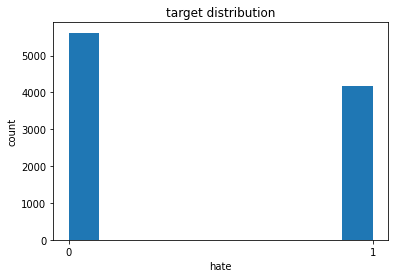

In [ ]:

%matplotlib inline

plt.hist(labels)
plt.xlabel('hate')
plt.ylabel('count')
plt.title('target distribution')
plt.xticks(np.arange(len(np.unique(labels))));


### Prepare Data


In [ ]:
# Tokenize with XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
padded_sequences = tokenizer(list(text), padding=True)
print (f"tokenized inputs {padded_sequences['input_ids'][0]}")


tokenized inputs [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

In [ ]:
list(text)[:10]
# padded_sequences.keys()

["!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...",
 '" &amp; you might not get ya bitch back &amp; thats that "',
 '" Keeks is a bitch she curves everyone " lol I walked into a conversation like this. Smh',
 '" Murda Gang bitch its Gang Land "',
 '" bad bitches is the only thing that i like "',
 '" bitch plz whatever "',
 '" bitches get cut off everyday B "',
 '" cancel that bitch like Nino "',
 '" got ya bitch tip toeing on my hardwood floors " &#128514; http://t.co/cOU2WQ5L4q',
 '" her pussy lips like Heaven doors " &#128524;']

In [ ]:
padded_sequences.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

### Split into training and validation datasets

In [ ]:
# include <your code>
# Use train_test_split to split our data into train and validation sets for training
input_ids = padded_sequences['input_ids']
attention_masks = padded_sequences['attention_mask']

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)



### Convert to tensors

In [ ]:
# include <your code>
# Convert data into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

### Prepare training data generators

In [ ]:
# include <your code>
batch_size = 32

# Create an iterator of train data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create an iterator of validation data with torch DataLoader 
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


### Load pretrained XLNet model, setup optimizer


In [ ]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print (torch.cuda.get_device_name(0))

# include <your code>


In [ ]:
model_path = './xlnet_humor_detection_state_dict.pth'

if os.path.exists(model_path):
    print ("Loading weights from saved model...")
    model.load_state_dict(torch.load(model_path, map_location=device))

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

num_labels = 2

# model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
#                                                       num_labels=num_labels)
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased',
                                                       num_labels=num_labels)

model.to(device)

# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

### Model Train function 

In [ ]:
# include <your code>
def train(model, iterator, optimizer):

    model.train()  

    epoch_loss = 0

    for step, batch in enumerate(iterator):
        
        #retrieve input data
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        #resets the gradients after every batch
        optimizer.zero_grad()

        # Forward pass
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output['loss']
        
        # Backward pass
        loss.backward()
        
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        
        # loss
        epoch_loss += loss.item()

        if step%50==0:
            print (f"step: {step}")

    
    return epoch_loss / len(iterator)

### Model Evaluate function

In [ ]:
# include <your code>
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Evaluate
def evaluate(model, iterator):
    
    #initialize every epoch
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    for batch in iterator:
        
        #retrieve input data
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        #deactivates autograd
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = output['logits']

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        epoch_acc += tmp_eval_accuracy
        
    return epoch_acc / len(iterator)


### Train the model

In [ ]:
from tqdm import trange

# include <your code>
N_EPOCHS = 3
best_valid_acc = 0

# BERT training loop
for _ in trange(N_EPOCHS, desc="Epoch"):  

    #train the model
    train_loss = train(model, train_dataloader, optimizer)
    
    #evaluate the model
    valid_acc = evaluate(model, validation_dataloader)
    
    #save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        print ("saving model ...")
        torch.save(model.state_dict(), model_path)
    
    print(f'\t Train Loss: {train_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

### Predict

In [ ]:
if os.path.exists(model_path):
    print ("Loading weights from saved model...")
    model.load_state_dict(torch.load(model_path, map_location=device))

model.to('cpu')
model.eval()

def predict(model, sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    output = model(**inputs)
    logits = output.logits
    logits = logits.detach().cpu().numpy()

    pred = np.argmax(logits, axis=1)[0]
    return 'Humor' if pred == 1 else 'Not a humor'

Loading weights from saved model...


In [ ]:
#Humor or not question
predict(model, "Where do eskimos keep their money? in snowbanks.")


'Humor'

In [ ]:
#Humor or not question
predict(model, "How many optometrists does it take to screw in a lightbulb? one... or two? one... or two?")


'Humor'

In [ ]:
#Humor or not question
predict(model, "Mcdonald's will officially kick off all-day breakfast on october 6")

'Not a humor'

In [ ]:
#Humor or not question
predict(model, "The journey to labor land: how women can reclaim their birth rights")

'Not a humor'